## LSTM层的输入形状
### 普通层的输入形状
普通层要求输入一个二维的张量，第一维的长度a表示的是一共处理a个第二维的数据，第二维的长度b表示此层的输入的样式  
即一次将b个数据输入到层中，一共计算a次。  
例如：
- 将一个张量`A = [[1,2,3],[4,5,6]]`输入到某个层中  
这个层如果指定`input_shape`，那么必须为`(3, )`  
不指定形状的话，会在传入张量时根据输入的张量A生成为`(3, )`
- 这个层可以传入多个`(3, )`的数据，所以可以是任意符合`(None, 3)`形式的数据，例如A的形状`(2, 3)`  
将A输入到层后，会分两次分别将`[1,2,3]`和`[4,5,6]`传入  
层的输出也是二维，传入了几批数据，就会计算出几个输出数据，第一维长度与输入数据的第一维长度相同
- 例如layer有两个神经元，那么一般一次有两个输出  
将A输入后，将输出两次，每次输出两个值  
例如输出可能为`[[1,2],[4,5]]`  

### LSTM层的输入形状
#### 输入形式
LSTM层输入的形状要求为**三维**，第一维长度a任然是表示一次计算a次数据，最后一维的长度b表示网络的输入的样式  
**第二维的长度p表示时间相关的这个序列的长度，例如采集的10s的动作，每秒采集10次，采集了6轴数据，那么此序列长度（二维长度）为100，三维长度为6**  
例如：
- 输入数据张量
```
A=[
        [[1,2],[2,3],[4,5]],
        [[1,4],[2,5],[3,6]]
    ]
```
表示输入了2批数据，每批数据的序列长度为3，单个数据包含两个量  

#### 输入序列不定长

## MPU9250动作识别
### 数据载入函数

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
def load_data(dirName):
    # ,"magX.txt","magY.txt","magZ.txt"
    fileNameSet=["accX.txt","accY.txt","accZ.txt","gyroX.txt","gyroY.txt","gyroZ.txt"]
    # dirName = "./dataset/myHAR/"
    Xdata = [] # 三维数组 第一维230个元素， 第二维若干个， 第三维9
    Ydata = []
    Odata = [] # 三维数组 第一维9个元素是9个轴， 第二维230个是230条数据， 第三维若干是一条数据的
    for fn in fileNameSet:
        i = 0
        d2 = [] # Odata的一个分量 临时
        with open(dirName+fn, 'r', encoding='utf-8') as f:
            for line in f:
                th = line[:-2].split(' ') # 一个list 一行数据的string的list
                th = list(map(int, th))   #转换为int的list
                d2.append(th) # 一维的加入进去
            Odata.append(d2)
    # print(len(Odata), len(Odata[0]), len(Odata[0][8]))
    for i in range(0, len(Odata[0])): # 0~230
        hol = [] # 不固定个数
        for j in range(0, len(Odata[0][i])): # 0~bgd
            th = []
            for k in range(0, 6): # 0~9
                th.append(Odata[k][i][j])
            hol.append(th)
        Xdata.append(hol)
    # print(len(Xdata), len(Xdata[80]), len(Xdata[0][8]))
    with open(dirName+"label.txt", 'r', encoding='utf-8') as f:
        for line in f:
            th = int(line)
            th = [1 if i==th else 0 for i in range(1, 9)]
            Ydata.append(th)
    return Xdata,Ydata

In [103]:
def load_data_temp():
    fileName = "./dataset/myHAR/accX.txt"
    Xdata = []
    with open(fileName, 'r', encoding='utf-8') as f:
        for line in f:
            th = line[:-2].split(' ')
            th = list(map(int, th))
            Xdata.append(th)
    Xdata = tf.ragged.constant(Xdata)
    return Xdata

In [2]:
from tensorflow.keras import layers
keras_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 2), dtype=tf.float32, ragged=True),
    tf.keras.layers.LSTM(2, dtype=tf.float32)
])
keras_model.summary()
# ly = layers.LSTM(2, ragged=True)
x = tf.ragged.constant([[[1,2],[1,2]],[[1,3],[1,3],[1,4]]], dtype=tf.float32)
y = keras_model(x)
y 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2)                 40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.02884993,  0.11127541],
       [-0.00792883,  0.1351562 ]], dtype=float32)>

### 载入数据

In [15]:
Xdata,Ydata = load_data("./dataset/myHAR/")
print(len(Xdata), len(Xdata[0]), len(Xdata[7][0]))
Xdata = tf.ragged.constant(Xdata, dtype=tf.float32)
Ydata = tf.constant(Ydata, dtype=tf.float32)
print(Xdata)
print(Ydata)

230 118 6
<tf.RaggedTensor [[[2449.0, -8958.0, 14177.0, 182.0, 189.0, 754.0], [2214.0, -8878.0, 14115.0, -110.0, 490.0, 874.0], [2123.0, -8737.0, 14009.0, -235.0, 717.0, 998.0], [2179.0, -8861.0, 13752.0, -305.0, 843.0, 1078.0], [1887.0, -8829.0, 13587.0, -387.0, 864.0, 1119.0], [1481.0, -8931.0, 13596.0, -474.0, 701.0, 1084.0], [1586.0, -8973.0, 13821.0, -553.0, 444.0, 1029.0], [1651.0, -8749.0, 13953.0, -442.0, 179.0, 960.0], [1576.0, -8709.0, 14141.0, -282.0, -57.0, 949.0], [1907.0, -8566.0, 14109.0, -159.0, -299.0, 870.0], [2102.0, -8539.0, 14136.0, -87.0, -501.0, 727.0], [2161.0, -8667.0, 14353.0, -137.0, -618.0, 653.0], [2121.0, -8787.0, 14666.0, -240.0, -635.0, 614.0], [2490.0, -8926.0, 15098.0, -383.0, -572.0, 580.0], [2569.0, -8988.0, 15288.0, -634.0, -337.0, 547.0], [2484.0, -8873.0, 15321.0, -766.0, 90.0, 525.0], [2239.0, -8861.0, 15261.0, -847.0, 516.0, 464.0], [2278.0, -9024.0, 15154.0, -883.0, 938.0, 428.0], [2106.0, -9333.0, 15328.0, -879.0, 1201.0, 397.0], [2168.0, -940

### 搭建模型

In [16]:
MPU_Model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 6], dtype=tf.float32, ragged=True, name="MPU_Input"),
    #tf.keras.layers.LSTM(64, name="MPU_2"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), name="MPU_Layer1"),
    tf.keras.layers.Dense(16, name="MPU_Layer2"),
    tf.keras.layers.Dense(8, activation='softmax', name="MPU_Output")
], name="SuBand")
MPU_Model.summary()
MPU_Model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

Model: "SuBand"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MPU_Layer1 (Bidirectional)   (None, 128)               36352     
_________________________________________________________________
MPU_Layer2 (Dense)           (None, 16)                2064      
_________________________________________________________________
MPU_Output (Dense)           (None, 8)                 136       
Total params: 38,552
Trainable params: 38,552
Non-trainable params: 0
_________________________________________________________________


### 进行训练

In [17]:
history = MPU_Model.fit(Xdata, Ydata, epochs=200)
#y = MPU_Model.predict(Xdata)
# y = MPU_Model(Xdata)
# print(y.shape)
# print(Ydata.shape)

Epoch 1/200
8/8 [==============================] - 0s 41ms/step - loss: 2.0588 - accuracy: 0.2043
Epoch 2/200
8/8 [==============================] - 0s 40ms/step - loss: 1.6508 - accuracy: 0.4391
Epoch 3/200
8/8 [==============================] - 0s 38ms/step - loss: 1.4410 - accuracy: 0.5565
Epoch 4/200
8/8 [==============================] - 0s 37ms/step - loss: 1.2829 - accuracy: 0.6348
Epoch 5/200
8/8 [==============================] - 0s 35ms/step - loss: 1.1554 - accuracy: 0.6783
Epoch 6/200
8/8 [==============================] - 0s 35ms/step - loss: 1.0497 - accuracy: 0.6826
Epoch 7/200
8/8 [==============================] - 0s 35ms/step - loss: 0.9706 - accuracy: 0.7000
Epoch 8/200
8/8 [==============================] - 0s 35ms/step - loss: 0.8994 - accuracy: 0.7435
Epoch 9/200
8/8 [==============================] - 0s 37ms/step - loss: 0.8278 - accuracy: 0.7696
Epoch 10/200
8/8 [==============================] - 0s 35ms/step - loss: 0.7795 - accuracy: 0.7870
Epoch 11/200
8/8 [=

### 查看训练过程趋势

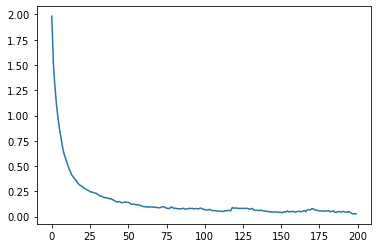

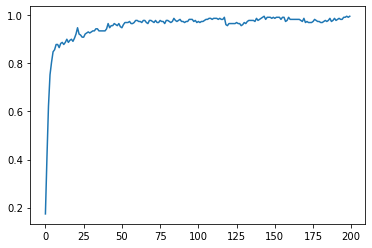

In [6]:
plt.plot(history.epoch, history.history.get('loss'))
plt.show()
plt.plot(history.epoch, history.history.get('accuracy'))

In [18]:
tf.__version__

'2.3.1'

### 调入测试集

In [18]:
Xtest,Ytest = load_data("./dataset/myHAR_Test/")
Xtest = tf.ragged.constant(Xtest, dtype=tf.float32)
Ytest = tf.constant(Ytest, dtype=tf.float32)
print(Xtest, Ytest)

<tf.RaggedTensor [[[1460.0, -5200.0, 16684.0, 94.0, 462.0, 4.0], [1312.0, -5380.0, 16520.0, 151.0, 392.0, 256.0], [1652.0, -5076.0, 16260.0, -151.0, 660.0, 154.0], [1488.0, -4996.0, 16172.0, -291.0, 706.0, 46.0], [1352.0, -4984.0, 16000.0, -410.0, 517.0, 93.0], [1420.0, -5076.0, 15916.0, -436.0, 188.0, 197.0], [1456.0, -5056.0, 16336.0, -325.0, -66.0, 98.0], [1376.0, -5232.0, 16296.0, -253.0, -81.0, 124.0], [1408.0, -5104.0, 16284.0, -459.0, -23.0, 47.0], [1400.0, -5248.0, 16688.0, -575.0, -9.0, 37.0], [1280.0, -5048.0, 16748.0, -686.0, 146.0, -108.0], [1108.0, -5304.0, 16704.0, -471.0, 565.0, 32.0], [1208.0, -5220.0, 16572.0, -477.0, 1043.0, 178.0], [892.0, -5224.0, 16400.0, -456.0, 1255.0, 374.0], [732.0, -5336.0, 16256.0, -470.0, 1150.0, 522.0], [944.0, -5556.0, 16220.0, -462.0, 651.0, 516.0], [852.0, -5536.0, 16616.0, -421.0, -135.0, 933.0], [932.0, -5776.0, 17096.0, -97.0, -699.0, 968.0], [1052.0, -5780.0, 17608.0, -38.0, -1130.0, 918.0], [968.0, -5708.0, 18492.0, -194.0, -1308.0,

### 测试准确率

In [19]:
result = MPU_Model.evaluate(Xtest,Ytest)
result

1/1 [==============================] - 0s 0s/step - loss: 0.9564 - accuracy: 0.8462


[0.9564017653465271, 0.8461538553237915]

In [454]:
res = MPU_Model.predict(Xtest)
class_names = ["抬手","放下","手腕右旋","手腕左旋","胳膊左转","胳膊右转","胳膊右回正","胳膊左回正"]
print([int(i*1000) for i in res[0]])
print("预测结果: ",[class_names[np.argmax(i)] for i in res])
print("独热标签: ",[class_names[np.argmax(i)] for i in Ytest])
a = "1 2 3 4 5 7 6 8 1 2 3 4 5 7 6 8 1 2 3 4 5 7 6 8 1 2"
a = [int(i)-1 for i in a.split(" ")]
print("真实标签: ",a)


[1000, 0, 0, 0, 0, 0, 0, 0]
预测结果:  ['抬手', '放下', '手腕右旋', '手腕左旋', '胳膊左转', '胳膊右回正', '胳膊右转', '胳膊左回正', '抬手', '放下', '手腕右旋', '手腕左旋', '胳膊左转', '胳膊右转', '胳膊右回正', '胳膊左回正', '抬手', '胳膊左转', '手腕右旋', '手腕左旋', '胳膊左转', '胳膊右回正', '胳膊右转', '胳膊左转', '抬手', '放下']
独热标签:  ['抬手', '放下', '手腕右旋', '手腕左旋', '胳膊左转', '胳膊右回正', '胳膊右转', '胳膊左回正', '抬手', '放下', '手腕右旋', '手腕左旋', '胳膊左转', '胳膊右回正', '胳膊右转', '胳膊左回正', '抬手', '放下', '手腕右旋', '手腕左旋', '胳膊左转', '胳膊右回正', '胳膊右转', '胳膊左回正', '抬手', '放下']
真实标签:  [0, 1, 2, 3, 4, 6, 5, 7, 0, 1, 2, 3, 4, 6, 5, 7, 0, 1, 2, 3, 4, 6, 5, 7, 0, 1]


### 数据集形状

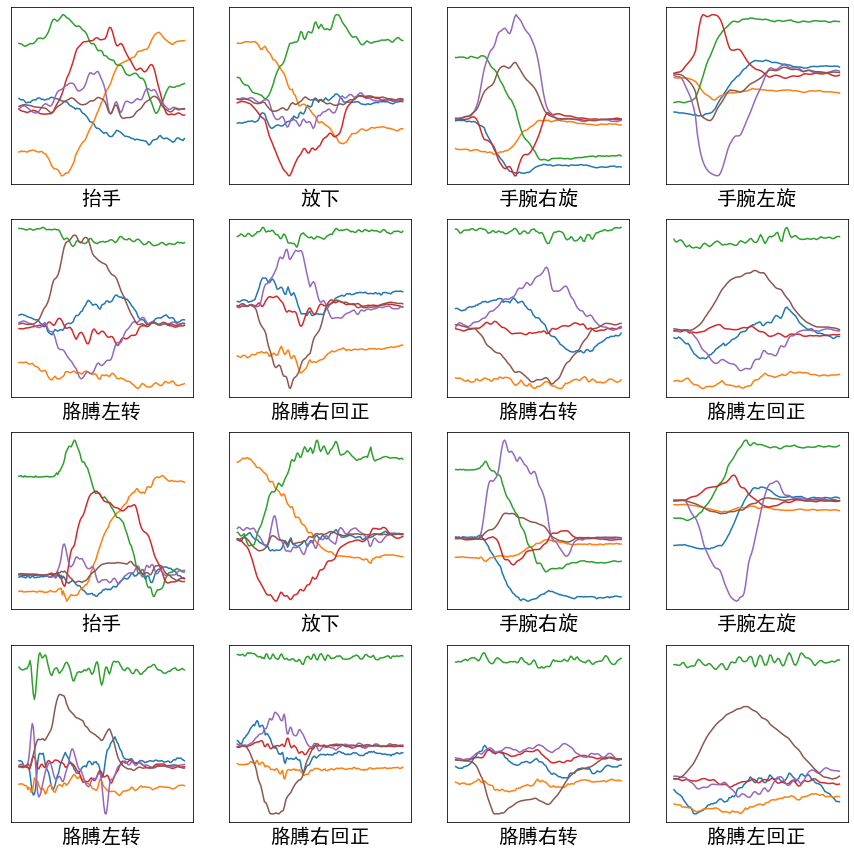

In [102]:
Xdata_,Ydata_ = load_data("./dataset/myHAR/")
# 在我的 notebook 里，要设置下面两行才能显示中文
plt.rcParams['font.family'] = ['sans-serif']
# 如果是在 PyCharm 里，只要下面一行，上面的一行可以删除
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.size'] = 20
class_names = ["抬手","放下","手腕右旋","手腕左旋","胳膊左转","胳膊右转","胳膊右回正","胳膊左回正"]
plt.figure(figsize=(15,15))
for k in range(16):
    plt.subplot(4,4,k+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.plot([i for i in range(len(Xdata_[k]))], [i[0] for i in Xdata[k]])
    plt.plot([i for i in range(len(Xdata_[k]))], [i[1] for i in Xdata[k]])
    plt.plot([i for i in range(len(Xdata_[k]))], [i[2] for i in Xdata[k]])
    plt.plot([i for i in range(len(Xdata_[k]))], [i[3] for i in Xdata[k]])
    plt.plot([i for i in range(len(Xdata_[k]))], [i[4] for i in Xdata[k]])
    plt.plot([i for i in range(len(Xdata_[k]))], [i[5] for i in Xdata[k]])
    plt.xlabel(class_names[np.argmax(Ydata_[k])])
plt.show()

## 模型部署
### 将模型导出

In [272]:
MPU_Model.save("./CompletedModels/SuBandv4/")

INFO:tensorflow:Assets written to: ./CompletedModels/SuBandv4/assets


In [455]:
tf.saved_model.save(MPU_Model, "./CompletedModels/SuBandv1/")

INFO:tensorflow:Assets written to: ./CompletedModels/SuBandv1/assets


In [456]:
!saved_model_cli show --dir ./CompletedModels/SuBandv1/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['args_0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 6)
        name: serving_default_args_0:0
    inputs['args_0_1'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: serving_default_args_0_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['MPU_Output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 8)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions

2020-11-24 16:17:12.103966: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-11-24 16:17:12.104236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 使用模型服务

In [10]:
Xtest = [[1460.0, -5200.0, 16684.0, 94.0, 462.0, 4.0], [1312.0, -5380.0, 16520.0, 151.0, 392.0, 256.0], [1652.0, -5076.0, 16260.0, -151.0, 660.0, 154.0], [1488.0, -4996.0, 16172.0, -291.0, 706.0, 46.0], [1352.0, -4984.0, 16000.0, -410.0, 517.0, 93.0], [1420.0, -5076.0, 15916.0, -436.0, 188.0, 197.0], [1456.0, -5056.0, 16336.0, -325.0, -66.0, 98.0], [1376.0, -5232.0, 16296.0, -253.0, -81.0, 124.0], [1408.0, -5104.0, 16284.0, -459.0, -23.0, 47.0], [1400.0, -5248.0, 16688.0, -575.0, -9.0, 37.0], [1280.0, -5048.0, 16748.0, -686.0, 146.0, -108.0], [1108.0, -5304.0, 16704.0, -471.0, 565.0, 32.0], [1208.0, -5220.0, 16572.0, -477.0, 1043.0, 178.0], [892.0, -5224.0, 16400.0, -456.0, 1255.0, 374.0], [732.0, -5336.0, 16256.0, -470.0, 1150.0, 522.0], [944.0, -5556.0, 16220.0, -462.0, 651.0, 516.0], [852.0, -5536.0, 16616.0, -421.0, -135.0, 933.0], [932.0, -5776.0, 17096.0, -97.0, -699.0, 968.0], [1052.0, -5780.0, 17608.0, -38.0, -1130.0, 918.0], [968.0, -5708.0, 18492.0, -194.0, -1308.0, 1073.0], [1116.0, -6272.0, 19960.0, -253.0, -1051.0, 1525.0], [1860.0, -6568.0, 21292.0, -13.0, -989.0, 1700.0], [2464.0, -7272.0, 24012.0, 1494.0, -1436.0, 826.0], [2460.0, -7592.0, 25204.0, 2923.0, -1979.0, 636.0], [2480.0, -7764.0, 25764.0, 4112.0, -1941.0, 488.0], [2640.0, -7740.0, 26032.0, 5505.0, -1920.0, 451.0], [3016.0, -7772.0, 26108.0, 6598.0, -1957.0, 326.0], [3040.0, -7648.0, 25660.0, 7805.0, -1871.0, 168.0], [3160.0, -7636.0, 25632.0, 8703.0, -1252.0, 285.0], [3172.0, -7608.0, 25372.0, 9922.0, -326.0, 459.0], [3452.0, -7216.0, 24648.0, 10924.0, 739.0, 485.0], [3396.0, -7024.0, 24048.0, 11501.0, 840.0, 431.0], [3820.0, -6524.0, 23704.0, 11688.0, 436.0, 65.0], [3824.0, -6268.0, 23648.0, 12202.0, 410.0, -507.0], [3664.0, -5960.0, 23432.0, 13135.0, 1463.0, -989.0], [3372.0, -5752.0, 22244.0, 14374.0, 2826.0, -1247.0], [3112.0, -5564.0, 20892.0, 14494.0, 3946.0, -1031.0], [2732.0, -4084.0, 20172.0, 14230.0, 4206.0, -1195.0], [2792.0, -3820.0, 19720.0, 14244.0, 3438.0, -1530.0], [2888.0, -3828.0, 19956.0, 14822.0, 1312.0, -2110.0], [2460.0, -3400.0, 19856.0, 15448.0, 230.0, -2747.0], [2552.0, -2888.0, 19520.0, 15678.0, 1668.0, -2929.0], [1856.0, -2024.0, 18272.0, 15359.0, 5783.0, -2936.0], [1592.0, -1616.0, 17264.0, 16218.0, 5348.0, -3201.0], [1452.0, -1032.0, 16180.0, 16386.0, 3829.0, -3562.0], [832.0, -500.0, 16108.0, 15741.0, 1392.0, -3796.0], [804.0, -96.0, 16496.0, 15214.0, 433.0, -3842.0], [1108.0, 368.0, 16564.0, 15290.0, 1559.0, -4552.0], [892.0, 872.0, 15580.0, 15649.0, 4435.0, -4749.0], [28.0, 1456.0, 14156.0, 15666.0, 5997.0, -5108.0], [-480.0, 1800.0, 13020.0, 15035.0, 5093.0, -4703.0], [-1020.0, 2540.0, 12716.0, 14711.0, 2032.0, -4791.0], [-356.0, 2912.0, 12748.0, 14529.0, -1143.0, -4775.0], [-276.0, 3348.0, 13128.0, 14613.0, -1690.0, -5364.0], [-528.0, 3984.0, 12596.0, 14881.0, -350.0, -5681.0], [-1220.0, 4352.0, 11704.0, 14954.0, 431.0, -5542.0], [-1336.0, 4900.0, 10928.0, 14108.0, -334.0, -4964.0], [-1332.0, 5404.0, 10916.0, 13482.0, -1808.0, -4596.0], [-1104.0, 5944.0, 11468.0, 12958.0, -2556.0, -4426.0], [-792.0, 6104.0, 11768.0, 12773.0, -1919.0, -4214.0], [-1088.0, 6364.0, 11572.0, 12883.0, 20.0, -4009.0], [-1508.0, 7324.0, 10896.0, 12770.0, 2806.0, -3642.0], [-1344.0, 7956.0, 9972.0, 12784.0, 4905.0, -2588.0], [-1768.0, 5780.0, 10840.0, 13602.0, 6525.0, -2262.0], [-1744.0, 10120.0, 8172.0, 12346.0, 6905.0, -1036.0], [-1812.0, 9600.0, 7892.0, 11712.0, 5850.0, -1586.0], [-2192.0, 10040.0, 7676.0, 11718.0, 5156.0, -1791.0], [-2252.0, 10580.0, 7300.0, 11935.0, 4876.0, -1814.0], [-2660.0, 10972.0, 6676.0, 11545.0, 4593.0, -1693.0], [-3072.0, 11164.0, 6036.0, 11308.0, 3854.0, -1477.0], [-3416.0, 11200.0, 5624.0, 11459.0, 2518.0, -1175.0], [-3988.0, 11692.0, 4264.0, 12171.0, -1230.0, -1056.0], [-4136.0, 12164.0, 3996.0, 12751.0, -6285.0, -633.0], [-3816.0, 12196.0, 3624.0, 12830.0, -7998.0, 253.0], [-2992.0, 12408.0, 4032.0, 11733.0, -5413.0, 1178.0], [-2120.0, 13148.0, 3972.0, 11132.0, -254.0, 1965.0], [-1412.0, 14236.0, 2840.0, 10813.0, 4130.0, 2155.0], [-1968.0, 14760.0, 2076.0, 10737.0, 6079.0, 1929.0], [-1480.0, 15112.0, 396.0, 11166.0, 4026.0, 1561.0], [-1996.0, 15976.0, -460.0, 11885.0, -932.0, -175.0], [-2744.0, 16552.0, -1416.0, 12136.0, -4370.0, -1297.0], [-2764.0, 16272.0, -1960.0, 11616.0, -5395.0, -2187.0], [-3320.0, 16616.0, -1680.0, -241.0, -1959.0, -896.0], [-3204.0, 16132.0, -400.0, -815.0, -2574.0, -638.0], [-3180.0, 16148.0, 940.0, -960.0, -4178.0, -497.0], [-2948.0, 15960.0, 2304.0, -1097.0, -4923.0, -474.0], [-2940.0, 15884.0, 3456.0, -1605.0, -4688.0, -538.0], [-2676.0, 15676.0, 4408.0, -1849.0, -3758.0, -216.0], [-2396.0, 15848.0, 5228.0, -2355.0, -3030.0, 68.0], [-2200.0, 16244.0, 5988.0, -2289.0, -2162.0, 40.0], [-2280.0, 16132.0, 6080.0, -1041.0, -1113.0, -3.0], [-2432.0, 15756.0, 5976.0, -633.0, -123.0, -63.0], [-2336.0, 15304.0, 6004.0, -929.0, 447.0, 170.0], [-2380.0, 15648.0, 6088.0, -1566.0, 1088.0, 225.0]]
len(Xtest)

Xtest = [[-2052.0, 15164.0, 5668.0, -526.0, 2869.0, 411.0], [-2300.0, 15596.0, 5136.0, -1139.0, 2926.0, 500.0], [-2008.0, 16152.0, 4760.0, -1025.0, 2000.0, 210.0], [-1804.0, 16408.0, 4132.0, 352.0, 1035.0, -242.0], [-2000.0, 15764.0, 3536.0, 362.0, 1097.0, -343.0], [-2800.0, 16428.0, 1288.0, -1240.0, 1560.0, -1048.0], [-3228.0, 16264.0, 300.0, -2397.0, 1314.0, -1414.0], [-3232.0, 16060.0, -648.0, -3180.0, 791.0, -1432.0], [-3268.0, 15648.0, -1304.0, -4121.0, -304.0, -1443.0], [-3564.0, 15384.0, -1660.0, -5193.0, -1435.0, -1298.0], [-3776.0, 15152.0, -1464.0, -6704.0, -2270.0, -826.0], [-3888.0, 15152.0, -852.0, -8438.0, -2567.0, -524.0], [-4008.0, 14652.0, 316.0, -9487.0, -3440.0, -265.0], [-4208.0, 13892.0, 1584.0, -10574.0, -3844.0, 245.0], [-4348.0, 13392.0, 2884.0, -11217.0, -3769.0, 891.0], [-4020.0, 13132.0, 4184.0, -11713.0, -3520.0, 1637.0], [-3552.0, 13048.0, 4868.0, -11475.0, -2890.0, 1755.0], [-3404.0, 12792.0, 5584.0, -10375.0, -2207.0, 2140.0], [-3180.0, 12544.0, 5748.0, -9869.0, -2386.0, 2923.0], [-2596.0, 12712.0, 6260.0, -10289.0, -3337.0, 3566.0], [-2284.0, 12300.0, 7048.0, -9787.0, -4225.0, 3476.0], [-1692.0, 11716.0, 7472.0, -9306.0, -2734.0, 3556.0], [-1944.0, 11740.0, 6792.0, -8527.0, 31.0, 3943.0], [-1620.0, 11472.0, 6280.0, -9553.0, -591.0, 4676.0], [-1168.0, 11288.0, 6608.0, -11049.0, -2367.0, 4342.0], [-1136.0, 9692.0, 7448.0, -11796.0, -4599.0, 2134.0], [-1436.0, 8472.0, 7764.0, -12117.0, -1832.0, 3174.0], [-1228.0, 8268.0, 8204.0, -13022.0, 2202.0, 4690.0], [-512.0, 8928.0, 7920.0, -13484.0, 4396.0, 5103.0], [28.0, 8780.0, 7176.0, -13896.0, 3065.0, 4114.0], [-388.0, 7780.0, 7684.0, -14866.0, -1593.0, 3206.0], [-140.0, 6208.0, 9500.0, -15914.0, -5173.0, 3414.0], [552.0, 5932.0, 11572.0, -16323.0, -4003.0, 3631.0], [1072.0, 6448.0, 12316.0, -15338.0, -694.0, 3914.0], [1468.0, 6104.0, 11948.0, -14468.0, 1164.0, 3771.0], [644.0, 5520.0, 11812.0, -14700.0, -766.0, 3126.0], [604.0, 4348.0, 13320.0, -15864.0, -5471.0, 3525.0], [1384.0, 3248.0, 16116.0, -16547.0, -7654.0, 4405.0], [2300.0, 2020.0, 18796.0, -15627.0, -2914.0, 6019.0], [2964.0, 2412.0, 18940.0, -14300.0, 5620.0, 6546.0], [2612.0, 3464.0, 16988.0, -13183.0, 11484.0, 5168.0], [1964.0, 3352.0, 14340.0, -12412.0, 10650.0, 3008.0], [832.0, 2252.0, 12928.0, -12822.0, 6890.0, 1153.0], [-8.0, 1096.0, 12424.0, -13719.0, 2703.0, 614.0], [-728.0, 184.0, 12604.0, -15559.0, 410.0, 1344.0], [-360.0, -1288.0, 15444.0, -17197.0, -613.0, 2711.0], [100.0, -788.0, 16064.0, -16495.0, -1134.0, 3096.0], [1452.0, -1364.0, 16576.0, -16404.0, -3753.0, 2570.0], [1956.0, -2068.0, 18196.0, -17116.0, -4768.0, 1802.0], [2000.0, -2868.0, 19692.0, -16995.0, -2515.0, 1628.0], [1344.0, -3636.0, 19568.0, -16112.0, 1024.0, 1880.0], [624.0, -3480.0, 18336.0, -14639.0, 2266.0, 1572.0], [416.0, -3908.0, 17636.0, -15044.0, -845.0, 1465.0], [848.0, -4484.0, 19224.0, -16478.0, -3625.0, 1289.0], [1824.0, -5392.0, 21500.0, -16990.0, -4012.0, 1060.0], [1740.0, -6128.0, 22516.0, -15903.0, -514.0, 981.0], [284.0, -6172.0, 21988.0, -13998.0, 2343.0, 671.0], [-808.0, -5724.0, 20828.0, -13598.0, 881.0, 1464.0], [232.0, -5928.0, 22464.0, -14559.0, -2823.0, 1657.0], [1636.0, -6908.0, 25304.0, -15216.0, -5398.0, 1324.0], [2760.0, -7552.0, 28180.0, -14414.0, -2772.0, 1625.0], [2728.0, -7364.0, 29064.0, -11925.0, 2601.0, 2085.0], [1944.0, -7316.0, 28620.0, -9343.0, 5106.0, 1969.0], [1492.0, -7408.0, 27576.0, -7893.0, 3552.0, 1483.0], [1104.0, -7944.0, 27300.0, -6638.0, 1552.0, 1337.0], [1104.0, -7968.0, 25260.0, -3730.0, 3732.0, 1519.0], [648.0, -7396.0, 23700.0, -2927.0, 3192.0, 1529.0], [620.0, -7048.0, 22592.0, -2222.0, 1345.0, 1392.0], [108.0, -7216.0, 21896.0, -1416.0, -206.0, 1192.0], [-36.0, -7460.0, 21108.0, -229.0, -308.0, 1436.0], [-376.0, -7244.0, 19472.0, 872.0, 714.0, 1721.0], [-444.0, -6500.0, 17924.0, 917.0, 1206.0, 1888.0], [-536.0, -6264.0, 16996.0, 558.0, 424.0, 1902.0], [-512.0, -5832.0, 16748.0, 59.0, -1000.0, 1772.0], [-624.0, -5924.0, 16904.0, 172.0, -2017.0, 1731.0], [-296.0, -6236.0, 17004.0, 108.0, -2225.0, 2039.0], [-560.0, -5836.0, 17008.0, 205.0, -1851.0, 2462.0], [-752.0, -5472.0, 16640.0, 483.0, -1399.0, 2812.0], [-424.0, -5164.0, 16652.0, 341.0, -1466.0, 2947.0], [-156.0, -5248.0, 16348.0, 600.0, -2218.0, 2595.0], [208.0, -5396.0, 16276.0, 273.0, -3363.0, 2141.0], [312.0, -5360.0, 16704.0, -116.0, -3936.0, 1681.0], [320.0, -5768.0, 17348.0, -139.0, -3524.0, 1709.0], [680.0, -5960.0, 17700.0, 17.0, -2669.0, 1795.0], [1152.0, -5688.0, 17704.0, 602.0, -1171.0, 1440.0], [1112.0, -5408.0, 17068.0, 943.0, 345.0, 858.0], [1140.0, -5348.0, 16340.0, 544.0, 1188.0, 407.0], [924.0, -5272.0, 15916.0, -70.0, 1558.0, 213.0], [872.0, -5340.0, 15820.0, -392.0, 1732.0, 174.0], [880.0, -5224.0, 15940.0, -408.0, 1622.0, 301.0], [1204.0, -4868.0, 15700.0, -172.0, 1347.0, -33.0], [1240.0, -4732.0, 15488.0, -364.0, 1234.0, -328.0], [1056.0, -4960.0, 15484.0, -866.0, 914.0, -724.0], [1024.0, -5044.0, 15900.0, -1164.0, 702.0, -880.0], [980.0, -5084.0, 16024.0, -1271.0, 621.0, -1172.0], [992.0, -5368.0, 16452.0, -1334.0, 642.0, -1326.0], [456.0, -5420.0, 16544.0, -1034.0, 489.0, -1467.0], [-156.0, -5896.0, 16572.0, -713.0, 382.0, -1377.0], [-100.0, -6044.0, 16472.0, -480.0, 43.0, -1090.0], [-208.0, -5792.0, 16472.0, -462.0, -98.0, -1004.0], [-76.0, -5704.0, 16820.0, -400.0, 11.0, -1001.0], [-144.0, -5908.0, 16412.0, -375.0, 239.0, -789.0], [-144.0, -5928.0, 16572.0, -356.0, 124.0, -455.0], [-140.0, -5992.0, 16804.0, -214.0, 30.0, -115.0], [-192.0, -5712.0, 16912.0, -204.0, 137.0, -88.0], [504.0, -5600.0, 16668.0, -227.0, 852.0, -364.0], [256.0, -5716.0, 16560.0, -265.0, 992.0, -449.0], [-108.0, -5780.0, 16596.0, -221.0, 1006.0, -437.0], [-152.0, -5876.0, 16568.0, -244.0, 1003.0, -450.0]]
# Xtest = [[-2204.0, 15584.0, 4876.0, -658.0, 246.0, 129.0], [-1932.0, 15972.0, 4896.0, -307.0, 253.0, 113.0], [-2048.0, 16348.0, 4784.0, -7.0, -56.0, -86.0], [-1692.0, 16376.0, 4636.0, -37.0, 83.0, -334.0], [-1580.0, 16232.0, 4332.0, -238.0, 350.0, -693.0], [-2168.0, 16084.0, 4276.0, -327.0, 691.0, -835.0], [-2352.0, 16196.0, 3828.0, -661.0, 798.0, -905.0], [-2472.0, 16008.0, 3708.0, -821.0, 300.0, -886.0], [-2516.0, 16012.0, 3540.0, -713.0, -134.0, -773.0], [-2488.0, 15864.0, 3368.0, -868.0, 118.0, -1092.0], [-2460.0, 16468.0, 2280.0, -1650.0, 244.0, -1806.0], [-2308.0, 16464.0, 1612.0, -2060.0, 418.0, -2089.0], [-2512.0, 16572.0, 620.0, -2147.0, 832.0, -1735.0], [-2104.0, 16892.0, -792.0, -2131.0, 1158.0, -1619.0], [-2164.0, 17276.0, -2124.0, -3181.0, 997.0, -2317.0], [-2452.0, 16840.0, -3292.0, -4815.0, 185.0, -3717.0], [-2600.0, 16620.0, -3736.0, -6766.0, -1234.0, -4168.0], [-3060.0, 15840.0, -3608.0, -8593.0, -2647.0, -4256.0], [-2992.0, 14808.0, -3116.0, -10168.0, -3769.0, -4602.0], [-3260.0, 13832.0, -2348.0, -11428.0, -4335.0, -4670.0], [-3804.0, 12704.0, -1284.0, -12218.0, -4568.0, -4064.0], [-3508.0, 12460.0, -644.0, -13239.0, -4543.0, -3060.0], [-2632.0, 13264.0, 120.0, -13451.0, -4366.0, -1749.0], [-1976.0, 13228.0, 544.0, -13735.0, -4770.0, -2405.0], [-1800.0, 12300.0, 1536.0, -14760.0, -4815.0, -3652.0], [-2408.0, 10708.0, 2548.0, -15501.0, -4019.0, -4225.0], [-3136.0, 10384.0, 3132.0, -16187.0, -3294.0, -3805.0], [-3304.0, 10400.0, 3928.0, -16228.0, -3909.0, -2461.0], [-3024.0, 9804.0, 4632.0, -15752.0, -4971.0, -2050.0], [-3028.0, 9432.0, 5248.0, -16024.0, -5988.0, -2988.0], [-3892.0, 7160.0, 6044.0, -16981.0, -6389.0, -4136.0], [-3836.0, 6952.0, 6760.0, -18617.0, -7598.0, -3148.0], [-2956.0, 6960.0, 8092.0, -19830.0, -8796.0, -2826.0], [-2800.0, 5840.0, 9408.0, -19601.0, -8840.0, -3261.0], [-2976.0, 4332.0, 10100.0, -18881.0, -8615.0, -3507.0], [-2848.0, 3664.0, 10804.0, -19481.0, -9105.0, -2943.0], [-1456.0, 3364.0, 12920.0, -21135.0, -9184.0, -1703.0], [-760.0, 2932.0, 14776.0, -21007.0, -6186.0, -1972.0], [-1176.0, 2664.0, 14556.0, -19692.0, -2615.0, -2704.0], [-1304.0, 2112.0, 12928.0, -18091.0, -3892.0, -2886.0], [-1736.0, 1272.0, 13460.0, -18361.0, -8388.0, -2719.0], [-424.0, 468.0, 15796.0, -20200.0, -9485.0, -1595.0], [240.0, -332.0, 17752.0, -20342.0, -5782.0, -1124.0], [0.0, -300.0, 17548.0, -19090.0, -2563.0, -1256.0], [288.0, -480.0, 16220.0, -17437.0, -3753.0, -1580.0], [16.0, -1176.0, 16240.0, -17167.0, -5810.0, -2068.0], [108.0, -2372.0, 17232.0, -17958.0, -5264.0, -1319.0], [-140.0, -3108.0, 18104.0, -18618.0, -3110.0, -751.0], [392.0, -3364.0, 18300.0, -18392.0, -2784.0, -337.0], [944.0, -3760.0, 18652.0, -17482.0, -4437.0, -1237.0], [664.0, -5256.0, 21208.0, -17844.0, -2763.0, -470.0], [1128.0, -5644.0, 21856.0, -17124.0, -1959.0, -760.0], [972.0, -5628.0, 21712.0, -14795.0, -3137.0, -1106.0], [224.0, -5668.0, 21580.0, -13819.0, -4069.0, -800.0], [36.0, -6592.0, 22096.0, -13446.0, -2521.0, 45.0], [652.0, -7500.0, 22424.0, -13058.0, -547.0, 108.0], [736.0, -7040.0, 21832.0, -12961.0, 857.0, -423.0], [-68.0, -6756.0, 20964.0, -11984.0, 506.0, -231.0], [4.0, -7584.0, 21096.0, -11299.0, -1348.0, -255.0], [696.0, -7968.0, 22156.0, -11319.0, -3505.0, -371.0], [972.0, -8268.0, 23924.0, -11286.0, -3088.0, -276.0], [1052.0, -8408.0, 24752.0, -10356.0, -690.0, -4.0], [208.0, -8580.0, 23928.0, -8690.0, 1332.0, -243.0], [168.0, -9076.0, 22968.0, -6611.0, 1270.0, 147.0], [268.0, -9092.0, 22884.0, -6227.0, -110.0, -86.0], [-152.0, -9384.0, 23344.0, -5707.0, -357.0, -29.0], [-492.0, -9160.0, 23500.0, -4501.0, 112.0, 629.0], [-168.0, -8956.0, 22920.0, -3087.0, 350.0, 1058.0], [-88.0, -8812.0, 21932.0, -1707.0, 345.0, 1249.0], [-48.0, -8440.0, 21148.0, -900.0, 57.0, 1452.0], [-12.0, -7980.0, 19728.0, 818.0, 709.0, 2075.0], [224.0, -7404.0, 19084.0, 1441.0, 851.0, 2087.0], [184.0, -7120.0, 18528.0, 1873.0, 621.0, 1918.0], [220.0, -6964.0, 18160.0, 1920.0, 469.0, 1750.0], [280.0, -6680.0, 17684.0, 1898.0, 169.0, 1417.0], [56.0, -6472.0, 17416.0, 1906.0, -148.0, 1074.0], [168.0, -6384.0, 17068.0, 1628.0, 65.0, 776.0], [216.0, -6328.0, 16720.0, 1547.0, 176.0, 604.0], [-116.0, -6092.0, 16460.0, 1430.0, 148.0, 557.0], [-56.0, -5980.0, 16296.0, 1304.0, -144.0, 402.0], [-204.0, -5752.0, 16216.0, 1256.0, -621.0, 5.0], [-256.0, -5720.0, 16152.0, 1045.0, -928.0, 202.0]]
len(Xtest)
# Xdata = "[[1460, -5200, 16684, 94, 462, 4],  [1312, -5380, 16520, 151, 392, 256],  [1652, -5076, 16260, -151, 660, 154],  [1488, -4996, 16172, -291, 706, 46],  [1352, -4984, 16000, -410, 517, 93],  [1420, -5076, 15916, -436, 188, 197],  [1456, -5056, 16336, -325, -66, 98],  [1376, -5232, 16296, -253, -81, 124],  [1408, -5104, 16284, -459, -23, 47],  [1400, -5248, 16688, -575, -9, 37],  [1280, -5048, 16748, -686, 146, -108],  [1108, -5304, 16704, -471, 565, 32]]"
# #Xdata = "[[1460, -5200, 16684, 94, 462, 4]]"
# aaa = [[1460, -5200, 16684, 94, 462, 4],  [1312, -5380, 16520, 151, 392, 256],  [1652, -5076, 16260, -151, 660, 154],  [1488, -4996, 16172, -291, 706, 46],  [1352, -4984, 16000, -410, 517, 93],  [1420, -5076, 15916, -436, 188, 197],  [1456, -5056, 16336, -325, -66, 98],  [1376, -5232, 16296, -253, -81, 124],  [1408, -5104, 16284, -459, -23, 47],  [1400, -5248, 16688, -575, -9, 37],  [1280, -5048, 16748, -686, 146, -108],  [1108, -5304, 16704, -471, 565, 32]]
# len(aaa)
#


109

In [13]:
import requests
import json
import tensorflow as tf
# Xtest,Ytest = load_data("./dataset/myHAR_Test/")
# Xtest = tf.ragged.constant(Xtest, dtype=tf.float32)
#data = json.dumps({"signature_name":"__saved_model_init_op","instances":[]})
data = json.dumps({"signature_name":"serving_default","inputs":{"args_0":Xtest, "args_0_1":[0,109]}})
# data = '{"instances":[[[[2449.0], [-8958.0], [14177.0], [182.0], [189.0], [754.0]], [[2214.0], [-8878.0], [14115.0], [-110.0], [490.0], [874.0]]]]}'
# data = '{"signature_name":"serving_default","instances":[{"args_0":'+Xtest+',"args_0_1":1}]}'
headers = {"content-type": "application/json"}
json_response = requests.post('http://10.102.14.92:8501/v1/models/SuBandv2:predict', data=data, headers=headers)
#json_response = requests.post('http://10.102.24.217:2333/v1/models/SuBandv2:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)
print(json_response.text)

{
    "outputs": [
        [
            8.74782291e-09,
            1.0,
            5.96182304e-09,
            4.71633665e-09,
            1.18984e-09,
            9.93956e-11,
            1.86396454e-11,
            7.45073274e-12
        ]
    ]
}


In [473]:
res = MPU_Model.predict([Xtest])
res

array([[7.3918125e-09, 9.9999988e-01, 3.8647826e-08, 9.8183371e-08,
        4.5720925e-09, 2.0361071e-09, 3.0285177e-09, 5.8958949e-10]],
      dtype=float32)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

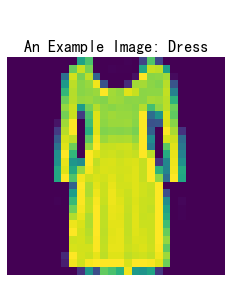

In [179]:

from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print(data)

In [344]:
xxxx = [[0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00352746248, 0.0519179702, 0.00233799219, 0.0788978636, 0.136730164, 0.0356667638, 0.0334613323, 0.0940043628], [0.00352633, 0.0519163907, 0.00233683, 0.0788820386, 0.136734098, 0.0356552601, 0.0334568024, 0.0940010846], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00224980712, 0.0497048795, 0.00134721398, 0.0586622357, 0.142722756, 0.0220913887, 0.0273054242, 0.0893093646], [0.00352746248, 0.0519179702, 0.00233799219, 0.0788978636, 0.136730164, 0.0356667042, 0.0334613323, 0.0940043628], [0.00353351235, 0.0519692898, 0.00233945251, 0.0787892044, 0.136837631, 0.0357123315, 0.033542186, 0.093949616], [0.00249648094, 0.0427903235, 0.00221973658, 0.0544485748, 0.133944452, 0.0372436643, 0.0246750116, 0.0741624832], [0.00364851952, 0.0537405908, 0.00295799971, 0.0368397832, 0.162537068, 0.0512454808, 0.0435065329, 0.0624560118], [0.00364851952, 0.0537405908, 0.00295799971, 0.0368397832, 0.162537068, 0.0512454808, 0.0435065329, 0.0624560118], [0.00339606404, 0.0634191334, 0.00180515647, 0.0411779881, 0.173133254, 0.0304526985, 0.0493970215, 0.0771001577], [0.00333327055, 0.0637626052, 0.00174286962, 0.0400472581, 0.171964079, 0.0309297442, 0.0499481261, 0.0780751109], [0.00169497728, 0.0702972412, 0.000512182713, 0.0156790316, 0.140010267, 0.0402981639, 0.0635872185, 0.0961729884], [0.00169497728, 0.0702972412, 0.000512182713, 0.0156790316, 0.140010267, 0.0402981639, 0.0635872185, 0.0961729884], [0.00169497728, 0.0702972412, 0.000512182713, 0.0156790316, 0.140010267, 0.0402981639, 0.0635872185, 0.0961729884], [0.00169497728, 0.0702972412, 0.000512182713, 0.0156790316, 0.140010267, 0.0402981639, 0.0635872185, 0.0961729884], [0.00112164021, 0.055182457, 0.000381916761, 0.0225904286, 0.11461091, 0.0293153524, 0.0353858173, 0.111039847], [0.00112164021, 0.055182457, 0.000381916761, 0.0225904286, 0.11461091, 0.0293153524, 0.0353858173, 0.111039847], [0.00112164021, 0.055182457, 0.000381916761, 0.0225904286, 0.11461091, 0.0293153524, 0.0353858173, 0.111039847], [0.000592291355, 0.0478546619, 0.000241011381, 0.0129442513, 0.0836515129, 0.0266255736, 0.0259083211, 0.123775721], [0.000848859549, 0.0783682466, 0.000324994326, 0.0195100009, 0.140980393, 0.0168892741, 0.018896848, 0.187866539], [0.00131174922, 0.101869971, 0.00052472949, 0.0189644694, 0.123610556, 0.0264786482, 0.0170935094, 0.237625241], [0.00256943703, 0.163441837, 0.00217679143, 0.0834839642, 0.220483124, 0.0420703, 0.0612813532, 0.378016263], [0.00284132361, 0.145041555, 0.00178992748, 0.0911964178, 0.245392054, 0.0560918748, 0.0659331083, 0.34397465], [0.00963193178, 0.211096585, 0.00574144721, 0.130189627, 0.353246629, 0.0672907829, 0.107341051, 0.515364766], [0.00963163376, 0.211096883, 0.00574123859, 0.13019079, 0.353235185, 0.0672916174, 0.107339352, 0.515352845], [0.00569561124, 0.216382086, 0.0034610033, 0.150081426, 0.200235039, 0.0826760232, 0.0829569101, 0.334771425], [0.00569561124, 0.216382086, 0.0034610033, 0.150081426, 0.200235039, 0.0826760232, 0.0829569101, 0.334771425], [0.00569561124, 0.216382086, 0.0034610033, 0.150081426, 0.200235039, 0.0826760232, 0.0829569101, 0.334771425], [0.0100670755, 0.291012228, 0.0071208179, 0.154556781, 0.240382105, 0.116440654, 0.100474566, 0.455991864], [0.0100670755, 0.291012228, 0.0071208179, 0.154556781, 0.240382105, 0.116440654, 0.100474566, 0.455991864], [0.0107358396, 0.283189178, 0.0067512095, 0.150592089, 0.230687201, 0.108759314, 0.0950583816, 0.447826177], [0.0293363333, 0.252139, 0.0166663229, 0.204918295, 0.242080361, 0.0685368478, 0.0712595, 0.385903984], [0.0225575268, 0.268069416, 0.00989109278, 0.14512974, 0.221122742, 0.0847882628, 0.0832156241, 0.433252722], [0.0098041594, 0.288098335, 0.0092741549, 0.142009735, 0.191641629, 0.0751804709, 0.0806123, 0.400500417], [0.0295800567, 0.418576688, 0.00522938371, 0.147783369, 0.161727607, 0.159538507, 0.0614001453, 0.412721753], [0.024746, 0.420676678, 0.0113558769, 0.217649519, 0.277769685, 0.144304603, 0.094730705, 0.487961441], [0.0381207168, 0.273295224, 0.0217905939, 0.191247493, 0.269248039, 0.0758721828, 0.0911298096, 0.356247842], [0.0379786193, 0.450671166, 0.103765965, 0.413378835, 0.337392211, 0.089194417, 0.164217681, 0.442742199], [0.0696469247, 0.581912875, 0.032884568, 0.252708375, 0.272046357, 0.235527962, 0.121199369, 0.475582123], [0.125631571, 0.381676078, 0.0806027055, 0.402432323, 0.211208671, 0.18381685, 0.0929857492, 0.443754107], [0.125631571, 0.381676078, 0.0806027055, 0.402432323, 0.211208671, 0.18381685, 0.0929857492, 0.443754107], [0.125631571, 0.381676078, 0.0806027055, 0.402432323, 0.211208671, 0.18381685, 0.0929857492, 0.443754107], [0.111954659, 0.664353, 0.0468687117, 0.423624277, 0.409460366, 0.256566644, 0.162921876, 0.490272492], [0.122674823, 0.550070405, 0.0571953952, 0.374372482, 0.314778984, 0.147910416, 0.122056156, 0.44414711], [0.104846686, 0.682260752, 0.105496228, 0.262005985, 0.387039065, 0.251845419, 0.219069123, 0.561691344], [0.252531499, 0.693162322, 0.190304637, 0.430988193, 0.484122485, 0.458703697, 0.402917445, 0.585400522], [0.42928344, 0.309975863, 0.161356, 0.822455347, 0.301169813, 0.238292813, 0.103592247, 0.290252566], [0.384985805, 0.223189741, 0.20315966, 0.782236338, 0.213218242, 0.174474061, 0.0628975928, 0.233126432], [0.42928344, 0.309975863, 0.161356, 0.822455347, 0.301169813, 0.238292813, 0.103592247, 0.290252566], [0.552371562, 0.196661025, 0.125531971, 0.727879763, 0.205290884, 0.156145036, 0.0799638331, 0.182793409], [0.552371562, 0.196661025, 0.125531971, 0.727879763, 0.205290884, 0.156145036, 0.0799638331, 0.182793409], [0.265349567, 0.134352714, 0.0426238775, 0.642002225, 0.133300364, 0.132255197, 0.0485432446, 0.0993354321], [0.154432595, 0.153073072, 0.0736134052, 0.705676377, 0.137966394, 0.14740935, 0.0375611186, 0.129764825], [0.246877313, 0.16969806, 0.066717267, 0.628245652, 0.0923872292, 0.183149755, 0.0285734236, 0.110275298], [0.283236831, 0.243606329, 0.0509469211, 0.686426342, 0.140297711, 0.25046891, 0.0486408472, 0.143542856], [0.514854729, 0.273237586, 0.163691849, 0.471413195, 0.0738916695, 0.0717865229, 0.0923958123, 0.106979519], [0.228024364, 0.245502144, 0.0475732386, 0.272289038, 0.0538206398, 0.0336285233, 0.0409144759, 0.110400587], [0.0433101952, 0.620298564, 0.183992267, 0.384682387, 0.303747356, 0.169023275, 0.424454451, 0.372193277], [0.285190165, 0.30521, 0.0469028354, 0.387817442, 0.049626261, 0.0328239501, 0.0681325793, 0.146282792], [0.285190165, 0.30521, 0.0469028354, 0.387817442, 0.049626261, 0.0328239501, 0.0681325793, 0.146282792], [0.252612829, 0.374162376, 0.054928869, 0.498297483, 0.0865068734, 0.0535440147, 0.101992249, 0.212754071], [0.433418423, 0.368998945, 0.0897936523, 0.713430464, 0.0911099613, 0.0653002, 0.113349259, 0.237891883], [0.299058676, 0.292085826, 0.0574060082, 0.583952963, 0.0851869285, 0.0537151098, 0.0894295, 0.196445316], [0.385979772, 0.237720907, 0.012937963, 0.528239965, 0.0459630489, 0.0523553789, 0.0377523601, 0.0880553722], [0.456047714, 0.170049101, 0.00732880831, 0.437930852, 0.0288219154, 0.0306316614, 0.0277604163, 0.0641148686], [0.84769994, 0.066683352, 0.144176781, 0.244303286, 0.0549656153, 0.0483632386, 0.0539366901, 0.0567044318], [0.574332952, 0.0927395523, 0.273131967, 0.402309, 0.156145036, 0.0952925384, 0.142916948, 0.100656539], [0.673963785, 0.129303694, 0.191185892, 0.490340948, 0.226657063, 0.13979885, 0.201731384, 0.167572081], [0.758293748, 0.0646114945, 0.107975125, 0.259277, 0.0684267, 0.0515513718, 0.0421766341, 0.0552263558], [0.943555653, 0.0366170108, 0.00840780139, 0.30671227, 0.00574636459, 0.0111922622, 0.0121795535, 0.0141466856], [0.947597206, 0.0339852571, 0.00805878639, 0.214342296, 0.0130814016, 0.00550320745, 0.0131144226, 0.0278607011], [0.993300557, 0.0503817797, 0.0110833347, 0.182754278, 0.0172736943, 0.00924658775, 0.0126582384, 0.0390253663], [0.946487606, 0.0215613544, 0.00552612543, 0.0858492553, 0.0056989491, 0.00691685081, 0.0103136, 0.0149892867], [0.882831156, 0.0238444805, 0.111852318, 0.165188104, 0.0702858865, 0.0690686107, 0.0731207132, 0.0641466081], [0.908703923, 0.0338764489, 0.128124148, 0.213528603, 0.11212948, 0.109604508, 0.0843306184, 0.0528829098], [0.826123714, 0.0308799148, 0.0409427583, 0.204482228, 0.0568163395, 0.08857131, 0.0467280447, 0.0322107971], [0.952797413, 0.0236044228, 0.00781109929, 0.0887222886, 0.0338718, 0.0493813455, 0.0253949463, 0.0292573273], [0.921647072, 0.0379522443, 0.0114784539, 0.124442875, 0.0490044057, 0.0658482, 0.0358291268, 0.04394719], [0.917598963, 0.0549719334, 0.011266917, 0.141524076, 0.0725737512, 0.0661787391, 0.0368833542, 0.0550490618], [0.917598963, 0.0549719334, 0.011266917, 0.141524076, 0.0725737512, 0.0661787391, 0.0368833542, 0.0550490618], [0.917598963, 0.0549719334, 0.011266917, 0.141524076, 0.0725737512, 0.0661787391, 0.0368833542, 0.0550490618], [0.893214643, 0.0420485437, 0.0161949098, 0.123851269, 0.0562822223, 0.0603061318, 0.0265053213, 0.0462393165], [0.893214643, 0.0420485437, 0.0161949098, 0.123851269, 0.0562822223, 0.0603061318, 0.0265053213, 0.0462393165], [0.893214643, 0.0420485437, 0.0161949098, 0.123851269, 0.0562822223, 0.0603061318, 0.0265053213, 0.0462393165], [0.940612853, 0.0257751346, 0.0332539976, 0.110116661, 0.0512140095, 0.0388415456, 0.0195626915, 0.0393771529], [0.899759293, 0.0359447598, 0.0101991594, 0.0530337095, 0.0585434139, 0.0260902643, 0.0152412653, 0.0416614413], [0.899759293, 0.0359447598, 0.0101991594, 0.0530337095, 0.0585434139, 0.0260902643, 0.0152412653, 0.0416614413]]
len(xxxx)

93

### 载入本地模型

In [1]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model("./CompletedModels/SuBandv1/")
model

In [25]:
res = model.predict([Xtest])
res.tolist()

[[7.39181249542753e-09,
  0.9999998807907104,
  3.8647826272608654e-08,
  9.818337076694661e-08,
  4.572092482391099e-09,
  2.0361070607322063e-09,
  3.0285176588762397e-09,
  5.895894883423125e-10]]